In [6]:
import numpy as np
import surprise as surp
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader

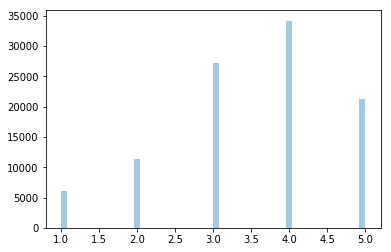

In [11]:
data = np.loadtxt('data.txt')

ratings = np.array(data[:, 2])
sns.distplot(ratings, kde=0)

In [10]:
reader = Reader(sep='\t')

data_load = Dataset.load_from_file('train.txt', reader)

trainset = data.build_full_trainset()
algo = SVD()

algo.fit(trainset)

In [3]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9348  0.9292  0.9303  0.9445  0.9422  0.9362  0.0062  
MAE (testset)     0.7391  0.7333  0.7326  0.7430  0.7409  0.7378  0.0041  
Fit time          4.15    3.93    4.07    3.96    4.12    4.05    0.09    
Test time         0.12    0.16    0.15    0.12    0.16    0.14    0.02    


{'test_rmse': array([0.93482396, 0.92915288, 0.93030116, 0.94447262, 0.94224945]),
 'test_mae': array([0.73909771, 0.73330086, 0.73263821, 0.74296981, 0.74085247]),
 'fit_time': (4.1506571769714355,
  3.928983211517334,
  4.068084955215454,
  3.9630918502807617,
  4.118180751800537),
 'test_time': (0.12432193756103516,
  0.1621990203857422,
  0.1530601978302002,
  0.11680102348327637,
  0.15660595893859863)}

In [22]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9320


0.9320481393241525